In [1]:
# Mapping Isochrones Around Park Entrances
# Author: Katrina Deloso
# In this notebook, I will identify the coordinate points around a park's entrances and build isochrones for 5, 10, 15, and 20 minute walks
# This notebook will serve as a pilot for our project goal, to map isochrones for walking and public transit around 17 regional parks in LA County
# I will be using Griffith Park as the pilot park, and mapping from the Vermont gate (34.117089, -118.297918) and the Ferndell/Western Canyon gate (34.109361162302825, -118.30763412707273)


In [2]:
# I begin by importing libraries for: spatial data, plotting, network analysis, street network analysis, and basemaps

import geopandas as gpd

import matplotlib.pyplot as plt

import networkx as nx

import osmnx as ox

import contextily as ctx

In [3]:
# configure the place, network type, trip times, and travel speed
# Since I'm mapping from coordinates, I use the coordinates as the place. In this notebook, I use the coordinates for the Ferndell entrance
center_point = (34.109361162302825, -118.30763412707273)
network_type = 'walk'
trip_times = [5, 10] #in minutes
meters_per_minute = 75 # travel distance per minute

In [4]:
%%time

# download the street network
# Since I'm graphing from coordinates, I use "graph_from_point" instead of "graph_from_place"
G = ox.graph_from_point(center_point, dist = 2000, network_type='walk')

CPU times: user 7.23 s, sys: 268 ms, total: 7.5 s
Wall time: 1min 41s


In [5]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

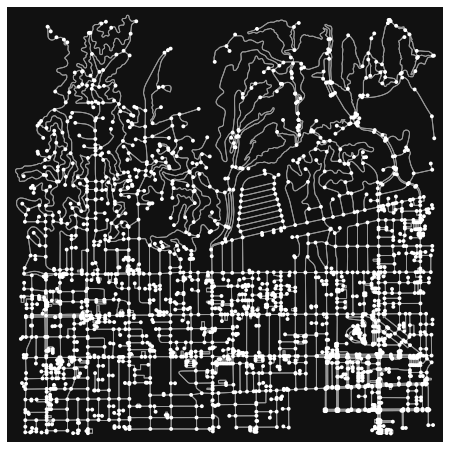

In [6]:
# quick plot using oxmnx
fig, ax = ox.plot_graph(G)

In [7]:
# project our network data to Web Mercator (measurements are in meters)
G = ox.project_graph(G, to_crs='epsg:3857')

In [8]:
# convert nodes and edges to geodataframes
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [9]:
# snapshot of nodes
gdf_nodes.head()

,y,x,osmid,highway,lon,lat,geometry
18153980,4.041641e+06,-1.316818e+07,18153980,traffic_signals,-118.291759,34.095563,POINT (-13168178.332 4041641.072)
20842309,4.042964e+06,-1.316818e+07,20842309,traffic_signals,-118.291800,34.105406,POINT (-13168182.930 4042964.219)
20842310,4.043728e+06,-1.316819e+07,20842310,traffic_signals,-118.291819,34.111085,POINT (-13168185.023 4043727.825)
20842311,4.043835e+06,-1.316770e+07,20842311,traffic_signals,-118.287462,34.111886,POINT (-13167700.015 4043835.495)
20954400,4.044514e+06,-1.316809e+07,20954400,NaN,-118.290957,34.116933,POINT (-13168089.143 4044514.059)


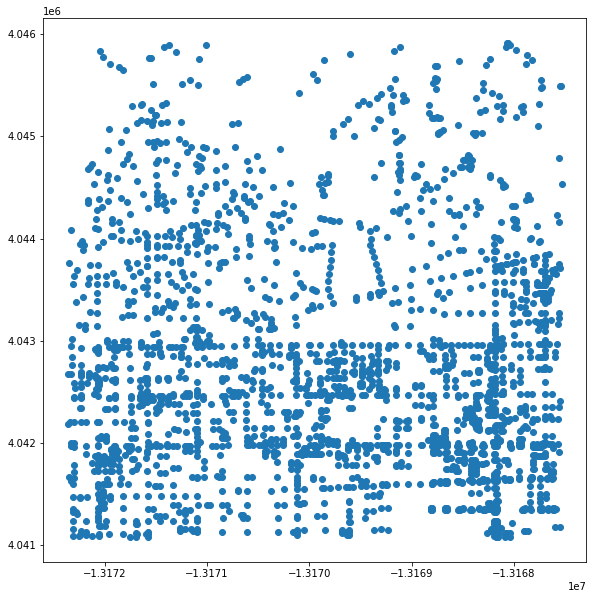

In [10]:
# plot nodes
gdf_nodes.plot(figsize=(10,10))

In [11]:
# snapshot edges
gdf_edges.head()

,osmid,name,highway,oneway,length,geometry,lanes,maxspeed,bridge,service,tunnel,access,u,v,key
0,180079314,Vermont Avenue,secondary,False,11.453,"LINESTRING (-13168178.332 4041641.072, -131681...",NaN,NaN,NaN,NaN,NaN,NaN,18153980,8248847138,0
1,398186763,Fountain Avenue,tertiary,False,13.929,"LINESTRING (-13168178.332 4041641.072, -131681...",4,30 mph,NaN,NaN,NaN,NaN,18153980,8248783211,0
2,398186765,Fountain Avenue,tertiary,False,12.192,"LINESTRING (-13168178.332 4041641.072, -131681...",5,30 mph,NaN,NaN,NaN,NaN,18153980,8248847123,0
3,398194808,Vermont Avenue,secondary,False,9.763,"LINESTRING (-13168178.332 4041641.072, -131681...",7,NaN,NaN,NaN,NaN,NaN,18153980,8248847146,0
4,398186772,Franklin Avenue,tertiary,False,22.862,"LINESTRING (-13168182.930 4042964.219, -131681...",3,NaN,NaN,NaN,NaN,NaN,20842309,7874168492,0


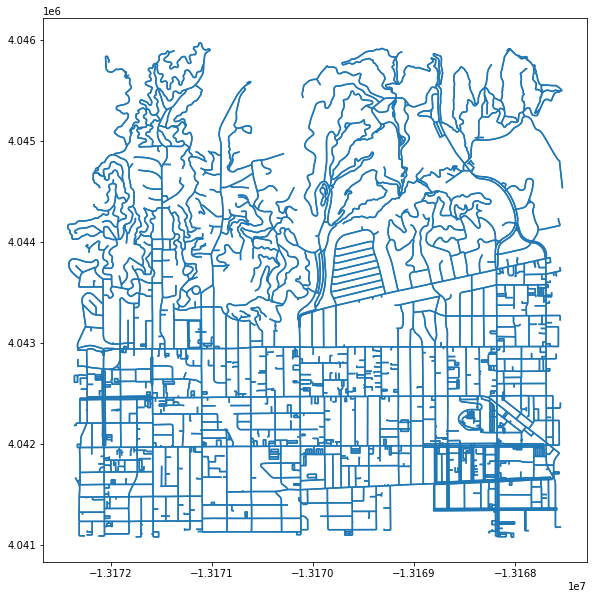

In [12]:
# plot edges
gdf_edges.plot(figsize=(10,10))

In [13]:
# get info on what streets (aka 'highways') are like
gdf_edges['highway'].value_counts()

residential                        2288
service                            1940
footway                             696
primary                             538
tertiary                            406
secondary                           304
track                               114
unclassified                        110
path                                 78
steps                                42
[steps, footway]                     18
living_street                        12
[steps, residential]                  8
[path, track]                         8
[residential, service]                8
secondary_link                        6
[path, residential]                   6
[service, footway]                    4
[secondary, residential]              2
[path, footway]                       2
[steps, residential, footway]         2
[residential, tertiary]               2
[residential, unclassified]           2
[primary, residential]                2
[residential, track]                  2


In [14]:
# how many streets are there?
gdf_edges['highway'].count()

6610

In [15]:
# Calculate network statistics
stats = ox.basic_stats(G, circuity_dist='euclidean')
stats

{'n': 2421,
 'm': 6610,
 'k_avg': 5.460553490293267,
 'intersection_count': 1945,
 'streets_per_node_avg': 2.781082197439075,
 'streets_per_node_counts': {0: 0, 1: 476, 2: 0, 3: 1531, 4: 407, 5: 6, 6: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.19661296984717058,
  2: 0.0,
  3: 0.6323833126807105,
  4: 0.1681123502684841,
  5: 0.0024783147459727386,
  6: 0.0004130524576621231},
 'edge_length_total': 509590.4659999985,
 'edge_length_avg': 77.0938677760966,
 'street_length_total': 254795.2329999999,
 'street_length_avg': 77.09386777609679,
 'street_segments_count': 3305,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 0.9415783217157856,
 'self_loop_proportion': 0.0030257186081694403,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

In [16]:
# Find the centroid node using the method from class

# find the bounds
minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
# calculate the centroid
centroid_x = (maxx-minx)/2 + minx
centroid_y = (maxy-miny)/2 + miny
print(centroid_x)
print(centroid_y)

# use osmnx's get_nearest_node command to get the id for the nearest node
center_node = ox.get_nearest_node(G, 
                                  (centroid_y,centroid_x), 
                                  method = 'euclidean')
print('The id for the nearest node is ' + str(center_node))

-13169947.538625993
4043497.7484698906
The id for the nearest node is 8291091132


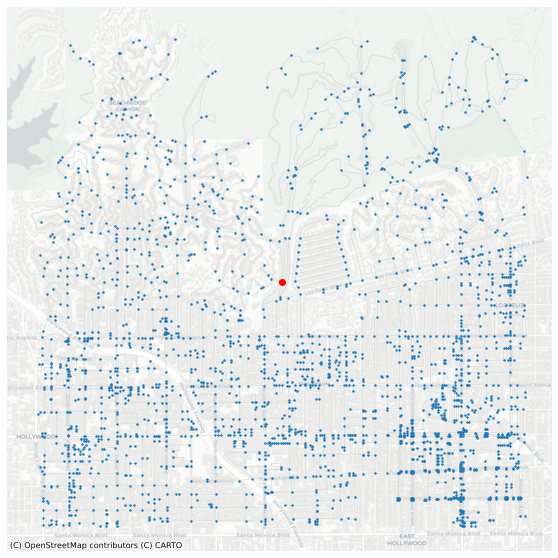

In [17]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               edgecolor='gainsboro', 
               zorder=10)

# add all nodes to ax
gdf_nodes.plot(ax=ax, 
               markersize=2, 
               zorder=20)

# add the center node in red also to ax
gdf_nodes.loc[[center_node]].plot(ax=ax,
                                  color='r', 
                                  zorder=30)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [18]:
# snapshot of edge data
gdf_edges[['osmid','name','highway','length']].sample(5)

,osmid,name,highway,length
66,179810911,NaN,unclassified,109.980
2485,154824792,NaN,service,56.961
6185,887096184,NaN,footway,7.162
6340,887716553,NaN,footway,7.718
1519,13433531,Beachwood Terrace,residential,192.582


In [19]:
# create a new column (using gdf['new column title'])
# calculate the time it takes to travel that edge
gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

In [20]:
# spotcheck walk time column
gdf_edges[['osmid','name','highway','length','walk_time']].sample(10)

,osmid,name,highway,length,walk_time
1679,"[398194781, 706831358]",North Vermont Avenue,secondary,55.859,0.744787
4202,404194394,Vine Street,primary,31.725,0.423000
1047,25887956,Fernwood Avenue,residential,53.557,0.714093
6376,887716565,NaN,footway,47.725,0.636333
4118,"[405134834, 405192243]",Franklin Avenue,secondary,45.304,0.604053
2512,154824792,NaN,service,56.961,0.759480
1584,398186780,Hollywood Boulevard,primary,70.925,0.945667
2584,13394075,Bonvue Avenue,residential,142.873,1.904973
2007,93726349,NaN,service,25.679,0.342387
5504,843399324,NaN,service,17.830,0.237733


In [21]:
# assign a color hex code for each trip time isochrone
# len(trip_times) = 4 - this is another way to get 4 colors
iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap='viridis', 
                                start=0, 
                                return_hex=True)
print(trip_times)
print(iso_colors)

[5, 10]
['#440154', '#fde725']


In [22]:
# create a list of "zipped" time/colors
# these are called tuples - pairs of values
time_color = list(zip(trip_times, iso_colors))
time_color

[(5, '#440154'), (10, '#fde725')]

In [23]:
time_color.sort(reverse=True)
print(time_color)

[(10, '#fde725'), (5, '#440154')]


In [24]:
# loop through the list of time/colors
for time,color in list(time_color):
    print('The color for '+str(time)+' minutes is ' + color)

The color for 10 minutes is #fde725
The color for 5 minutes is #440154


In [25]:
# loop through each trip time and associated color
for time, color in list(time_color):

    # for each trip time, create an egograph of nodes that fall within that distance
    subgraph = nx.ego_graph(G, center_node, radius=time, distance='time')

    print('There are ' + str(len(subgraph.nodes())) + ' nodes within ' + str(time) + ' minutes ')
    
    # for each of those nodes, update the gdf_nodes dataframe and assign it with its associated distance color
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = str(time) + ' mins'
        gdf_nodes.loc[node,'color'] = color
        
    # start with the farthest nodes, then override this each time you try to find nodes within a shorter distance

There are 221 nodes within 10 minutes 
There are 43 nodes within 5 minutes 


In [26]:
# spot check
gdf_nodes[['osmid','highway','time','color']].sample(20)

,osmid,highway,time,color
6734603748,6734603748,NaN,NaN,NaN
123305679,123305679,NaN,NaN,NaN
6789764445,6789764445,NaN,NaN,NaN
6735751441,6735751441,NaN,NaN,NaN
1903742419,1903742419,NaN,NaN,NaN
8248847185,8248847185,NaN,NaN,NaN
25075819,25075819,stop,NaN,NaN
6726874383,6726874383,NaN,NaN,NaN
6735212331,6735212331,NaN,NaN,NaN
1902424853,1902424853,NaN,NaN,NaN


In [27]:
# assign NaN values as a grey color
gdf_nodes['color'].fillna('#cccccc', inplace=True)

In [28]:
#spot check
gdf_nodes[['osmid','highway','time','color']].sample(5)

,osmid,highway,time,color
7849522510,7849522510,NaN,NaN,#cccccc
6735751442,6735751442,NaN,NaN,#cccccc
1671438353,1671438353,NaN,NaN,#cccccc
123060845,123060845,NaN,10 mins,#fde725
7594080262,7594080262,NaN,NaN,#cccccc


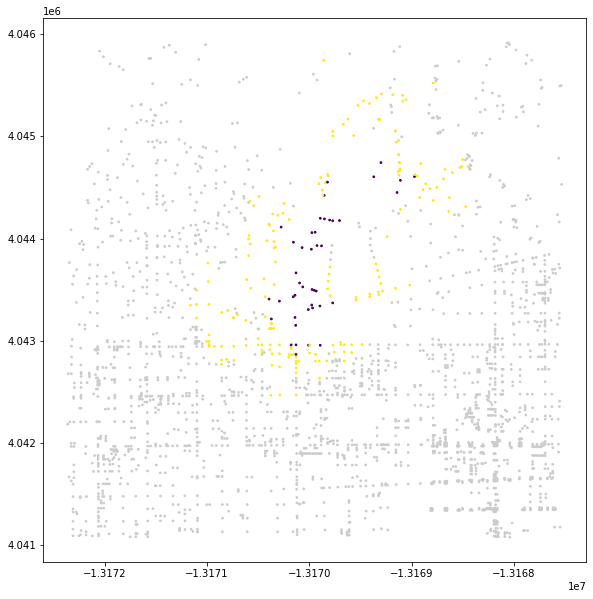

In [29]:
# map it
gdf_nodes.plot(figsize=(10,10),
               color=gdf_nodes['color'],
               markersize=3)

In [30]:
# create a list of nodes within a 5 minute walk
gdf_5 = gdf_nodes[gdf_nodes['time']=='5 mins']

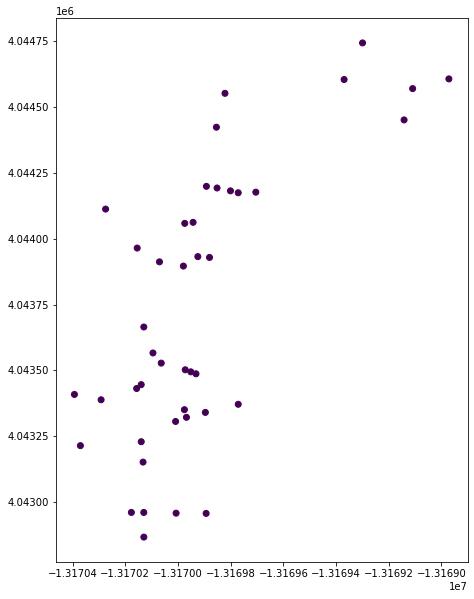

In [31]:
# plot it
gdf_5.plot(figsize=(10,10),color=gdf_5.color)

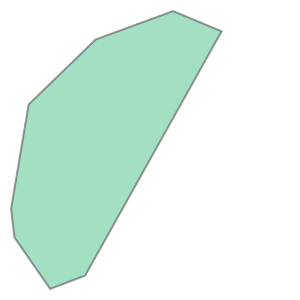

In [32]:
# combine all the points (.unary_union) and create a convex hull polygon (.convex_hull)
gdf_5.unary_union.convex_hull

In [33]:
# dissolve (collapse/group) the nodes by time
isochrones = gdf_nodes.dissolve("time")
isochrones

,geometry,y,x,osmid,highway,lon,lat,color
time,,,,,,,,
10 mins,"MULTIPOINT (-13171162.173 4043349.781, -131711...",4.044773e+06,-1.316850e+07,20954405,stop,-118.294664,34.118861,#fde725
5 mins,"MULTIPOINT (-13170393.156 4043409.072, -131703...",4.042961e+06,-1.317013e+07,21306014,traffic_signals,-118.309289,34.105382,#440154


In [34]:
# for each row, create a convex hull
isochrones = isochrones.convex_hull.reset_index()
isochrones

,time,0
0,10 mins,"POLYGON ((-13170374.644 4042469.078, -13170857..."
1,5 mins,"POLYGON ((-13170129.596 4042867.556, -13170370..."


In [35]:
# rename columns as 'time' and 'geometry'
isochrones.columns=['time','geometry']
#spot check
isochrones

,time,geometry
0,10 mins,"POLYGON ((-13170374.644 4042469.078, -13170857..."
1,5 mins,"POLYGON ((-13170129.596 4042867.556, -13170370..."


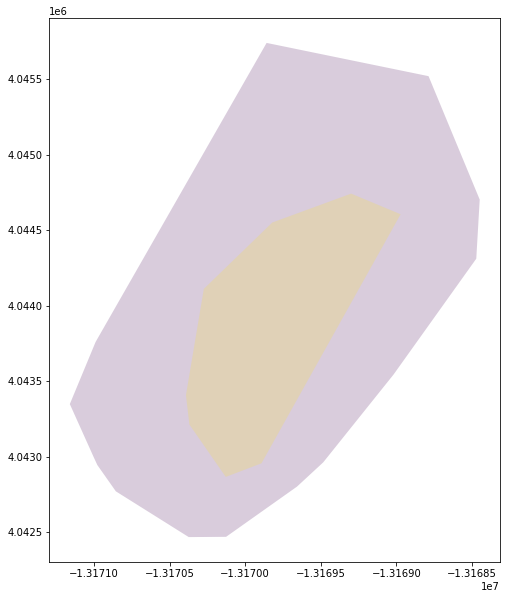

In [36]:
# map the isochrones!
isochrones.plot(figsize=(10,10),alpha=0.2,cmap='viridis')

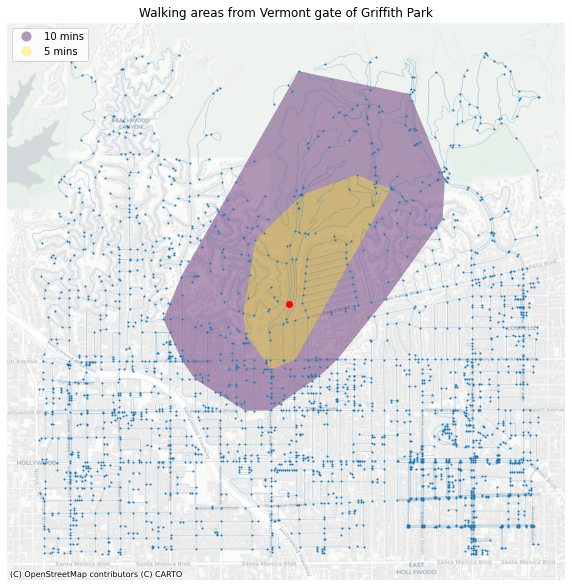

In [37]:
# Full isochrone map

# set up the subplots
fig, ax = plt.subplots(figsize=(10,15))

# add the isochrones
# for submaps, need ax=ax(because ax=subplot)
isochrones.plot(alpha=0.4, 
                ax=ax, 
                column='time', 
                cmap='viridis', 
                legend=True,
                zorder=1)

# add the center node in red
gdf_nodes.loc[[center_node]].plot(ax=ax,color='r', zorder=30)

# add all nodes
gdf_nodes.plot(ax=ax, 
               markersize=1, 
               zorder=10)

# add the edges
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               alpha=0.2,
               zorder=10)

# hide the axis
ax.axis('off')

# give it a title
ax.set_title('Walking areas from Vermont gate of Griffith Park')

# add the basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [38]:
# import more libraries for geometry shapes
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch

In [39]:
# make a better isochrone
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [40]:
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)

In [41]:
# Create an empty geopandas GeoDataFrame
better_isos = gpd.GeoDataFrame()
better_isos['geometry'] = None

In [42]:
# Need to sort trip times in reverse so that it starts with 20 min walkshed first
trip_times.sort(reverse=True)
print(time_color)

[(10, '#fde725'), (5, '#440154')]


In [43]:
for i in range(len(isochrone_polys)):
    better_isos.loc[i,'geometry'] = isochrone_polys[i]
    better_isos.loc[i,'time'] =  str(trip_times[i]) + ' mins'
better_isos

,geometry,time
0,"POLYGON ((-13170263.016 4042495.310, -13170202...",10 mins
1,"POLYGON ((-13170155.127 4042901.340, -13170155...",5 mins


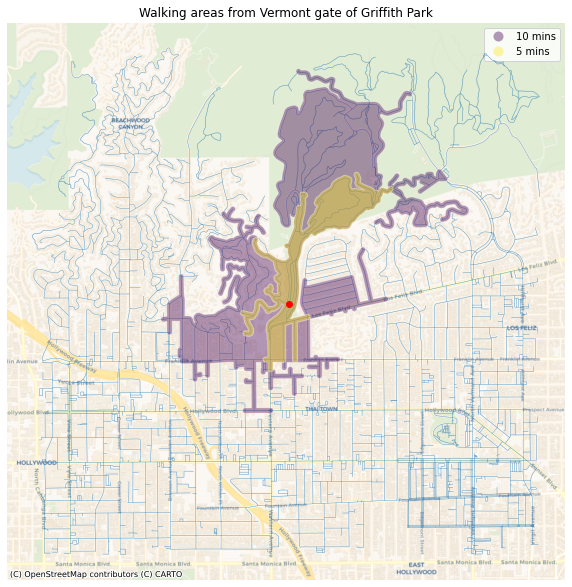

In [44]:
# create a beautiful map with all relevant layers
# set up the subplots
fig, ax = plt.subplots(figsize=(10,15))

# add the isochrones
better_isos.plot(alpha=0.4, 
                ax=ax, 
                column='time', 
                cmap='viridis', 
                edgecolor='white',
                 legend=True,
                zorder=20)

# add the center node in red
gdf_nodes.loc[[center_node]].plot(ax=ax,color='r', zorder=30)

# add all nodes
# gdf_nodes.plot(ax=ax, 
#                markersize=1, 
#                zorder=1)

# add the edges
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               alpha=0.4,
               zorder=10)

# hide the axis
ax.axis('off')

# give it a title
ax.set_title('Walking areas from Vermont gate of Griffith Park')

# add the basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Voyager)